In [1]:
import numpy as np
import pandas as pd 
from sklearn.metrics import accuracy_score
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio
pio.templates.default = "plotly_white"
import matplotlib.pyplot as plt
import os
from mplfinance.original_flavor import candlestick_ohlc
import matplotlib.dates as mdates
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV

In [2]:
folder_path = 'C:\\Users\\akshi_sh9bvdj\\Downloads\\archive\\stock_market_data\\forbes2000\\csv'
csv_files = [file for file in os.listdir(folder_path) if file.endswith('.csv')]

In [3]:
dataframes = [pd.read_csv(os.path.join(folder_path, file)) for file in csv_files]

In [4]:
# Combine All the datasets into 1
dataframes = []
for file in csv_files:
    # Read the CSV
    df = pd.read_csv(os.path.join(folder_path, file))
    
    # Add a new column representing the filename without the ".csv" extension
    filename_without_extension = os.path.splitext(file)[0]
    df.insert(0, 'Name', filename_without_extension)
    df['Name'] = filename_without_extension
    dataframes.append(df)

# Concatenate all DataFrames
stocks_df = pd.concat(dataframes, ignore_index=True)

# Save new merged Dataset
stocks_df.to_csv('merged_dataset_with_id.csv', index=False)

In [5]:
stocks_df.tail(5)

,Name,Date,Low,Open,Volume,High,Close,Adjusted Close
5601966,ZURVY,06-12-2022,47.810001,48.029999,42700.0,48.209999,47.980000,47.980000
5601967,ZURVY,07-12-2022,47.740002,47.959999,74800.0,48.130001,47.810001,47.810001
5601968,ZURVY,08-12-2022,47.880001,47.950001,72300.0,48.290001,48.160000,48.160000
5601969,ZURVY,09-12-2022,48.259998,48.470001,65600.0,48.740002,48.310001,48.310001
5601970,ZURVY,12-12-2022,48.044998,48.189999,13244.0,48.189999,48.044998,48.044998


In [6]:
print(stocks_df)

          Name        Date        Low       Open      Volume       High  \
0            A  18-11-1999  28.612303  32.546494  62546380.0  35.765381   
1            A  19-11-1999  28.478184  30.713518  15234146.0  30.758226   
2            A  22-11-1999  28.657009  29.551144   6577870.0  31.473534   
3            A  23-11-1999  28.612303  30.400572   5975611.0  31.205294   
4            A  24-11-1999  28.612303  28.701717   4843231.0  29.998213   
...        ...         ...        ...        ...         ...        ...   
5601966  ZURVY  06-12-2022  47.810001  48.029999     42700.0  48.209999   
5601967  ZURVY  07-12-2022  47.740002  47.959999     74800.0  48.130001   
5601968  ZURVY  08-12-2022  47.880001  47.950001     72300.0  48.290001   
5601969  ZURVY  09-12-2022  48.259998  48.470001     65600.0  48.740002   
5601970  ZURVY  12-12-2022  48.044998  48.189999     13244.0  48.189999   

             Close  Adjusted Close  
0        31.473534       27.066582  
1        28.880545       

In [7]:
# Convert Date column to datetime
stocks_df['Date'] = pd.to_datetime(stocks_df['Date'], format='%d-%m-%Y')
print(stocks_df)

          Name       Date        Low       Open      Volume       High  \
0            A 1999-11-18  28.612303  32.546494  62546380.0  35.765381   
1            A 1999-11-19  28.478184  30.713518  15234146.0  30.758226   
2            A 1999-11-22  28.657009  29.551144   6577870.0  31.473534   
3            A 1999-11-23  28.612303  30.400572   5975611.0  31.205294   
4            A 1999-11-24  28.612303  28.701717   4843231.0  29.998213   
...        ...        ...        ...        ...         ...        ...   
5601966  ZURVY 2022-12-06  47.810001  48.029999     42700.0  48.209999   
5601967  ZURVY 2022-12-07  47.740002  47.959999     74800.0  48.130001   
5601968  ZURVY 2022-12-08  47.880001  47.950001     72300.0  48.290001   
5601969  ZURVY 2022-12-09  48.259998  48.470001     65600.0  48.740002   
5601970  ZURVY 2022-12-12  48.044998  48.189999     13244.0  48.189999   

             Close  Adjusted Close  
0        31.473534       27.066582  
1        28.880545       24.836662  


In [8]:
stocks_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5601971 entries, 0 to 5601970
Data columns (total 8 columns):
 #   Column          Dtype         
---  ------          -----         
 0   Name            object        
 1   Date            datetime64[ns]
 2   Low             float64       
 3   Open            float64       
 4   Volume          float64       
 5   High            float64       
 6   Close           float64       
 7   Adjusted Close  float64       
dtypes: datetime64[ns](1), float64(6), object(1)
memory usage: 341.9+ MB


In [9]:
stocks_df.describe()

,Date,Low,Open,Volume,High,Close,Adjusted Close
count,5601971,5.555576e+06,5.555576e+06,5.555576e+06,5.555576e+06,5.555576e+06,5.555576e+06
mean,2008-07-17 12:31:32.920901888,1.789278e+07,1.789299e+07,3.055431e+06,1.789346e+07,1.789299e+07,-1.213999e+28
min,1970-01-02 00:00:00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-2.554577e+34
25%,2001-10-03 00:00:00,7.330000e+00,7.200000e+00,5.700000e+03,7.491303e+00,7.410000e+00,4.450642e+00
50%,2011-11-07 00:00:00,1.900000e+01,1.911000e+01,3.099000e+05,1.940000e+01,1.920000e+01,1.364000e+01
75%,2017-09-05 00:00:00,4.196000e+01,4.236000e+01,1.789100e+06,4.285000e+01,4.241000e+01,3.342836e+01
max,2022-12-12 00:00:00,8.324640e+12,8.324640e+12,7.421641e+09,8.324640e+12,8.324640e+12,3.904317e+31
std,NaN,8.180296e+09,8.180296e+09,2.360794e+07,8.180296e+09,8.180296e+09,1.102262e+31


## K Nearest Neighbour

### Based on the independent variables, KNN finds the similarity between new data points and old data points.

### We will implement the KNN model for only Tesla and Microsoft stocks¶

In [10]:
# Filter out Tesla data
tesla_df = stocks_df[stocks_df['Name'] == 'TSLA']

# Sort the dataframe by Date
tesla_df.sort_values(by='Date', inplace=True)
print(tesla_df)

         Name       Date         Low        Open       Volume        High  \
5031552  TSLA 2010-06-29    1.169333    1.266667  281494500.0    1.666667   
5031553  TSLA 2010-06-30    1.553333    1.719333  257806500.0    2.028000   
5031554  TSLA 2010-07-01    1.351333    1.666667  123282000.0    1.728000   
5031555  TSLA 2010-07-02    1.247333    1.533333   77097000.0    1.540000   
5031556  TSLA 2010-07-06    1.055333    1.333333  103003500.0    1.333333   
...       ...        ...         ...         ...          ...         ...   
5034684  TSLA 2022-12-06  175.330002  181.220001   92150800.0  183.649994   
5034685  TSLA 2022-12-07  172.220001  175.029999   84213300.0  179.380005   
5034686  TSLA 2022-12-08  169.059998  172.199997   97624500.0  175.199997   
5034687  TSLA 2022-12-09  173.360001  173.839996  104746600.0  182.500000   
5034688  TSLA 2022-12-12  170.389999  176.100006   36780366.0  177.359894   

              Close  Adjusted Close  
5031552    1.592667        1.592667  

C:\Users\akshi_sh9bvdj\AppData\Local\Temp\ipykernel_21464\3533593648.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tesla_df.sort_values(by='Date', inplace=True)


In [11]:
tesla_df.isnull().sum()

Name              0
Date              0
Low               0
Open              0
Volume            0
High              0
Close             0
Adjusted Close    0
dtype: int64

In [12]:
tesla_df['Date']

5031552   2010-06-29
5031553   2010-06-30
5031554   2010-07-01
5031555   2010-07-02
5031556   2010-07-06
             ...    
5034684   2022-12-06
5034685   2022-12-07
5034686   2022-12-08
5034687   2022-12-09
5034688   2022-12-12
Name: Date, Length: 3137, dtype: datetime64[ns]

In [13]:
# Set 'Date' column as the index
tesla_df.set_index('Date', inplace=True)

*********Tesla STOCK PRICE PREDICTION BY K-NEAREST NEIGHBORS*********
Shape of Training Data Set (2353, 1)
Shape of Test Data Set (784, 1)
(Root Mean Square Error) RMSE value on validation set: 205.44299141105506
R-squared: -3.0457617959249568
Adjusted R-squared: -3.0509354043596435


C:\Users\akshi_sh9bvdj\AppData\Local\Temp\ipykernel_21464\2780914730.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data_set['Predictions'] = preds


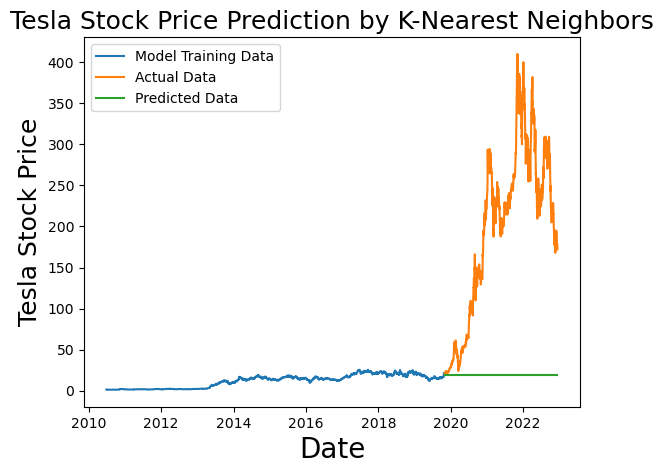

In [14]:
import datetime as dt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import neighbors
from sklearn.model_selection import GridSearchCV
from math import ceil
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score

def K_Nearest_Neighbours_Predict(df):
    shape = tesla_df.shape[0]
    tesla_df_new = tesla_df[['Close']]

    train_data_set = tesla_df_new.iloc[:ceil(shape * 0.75)]
    test_data_set = tesla_df_new.iloc[ceil(shape * 0.75):]

    print("*********Tesla STOCK PRICE PREDICTION BY K-NEAREST NEIGHBORS*********")
    print('Shape of Training Data Set', train_data_set.shape)
    print('Shape of Test Data Set', test_data_set.shape)

    x_train = train_data_set.index.values.reshape(-1, 1)  # Assuming index represents Date
    y_train = train_data_set[['Close']]
    x_test = test_data_set.index.values.reshape(-1, 1)  # Assuming index represents Date
    y_test = test_data_set[['Close']]

    scaler = MinMaxScaler()
    x_train_scaled = scaler.fit_transform(x_train)
    x_train = pd.DataFrame(x_train_scaled)
    x_test_scaled = scaler.transform(x_test)
    x_test = pd.DataFrame(x_test_scaled)

    params = {'n_neighbors': [2, 3, 4, 5, 6, 7, 8, 9]}
    knn = neighbors.KNeighborsRegressor()
    model = GridSearchCV(knn, params, cv=5)
    model.fit(x_train, y_train)
    preds = model.predict(x_test)
    RMS = np.sqrt(np.mean(np.power((np.array(y_test) - np.array(preds)), 2)))
    print('(Root Mean Square Error) RMSE value on validation set:', RMS)
    test_data_set['Predictions'] = preds

    # Calculate R-squared and adjusted R-squared
    r_squared = r2_score(y_test, preds)
    n = len(y_test)
    p = x_test.shape[1]  # Number of features
    adj_r_squared = 1 - (1 - r_squared) * (n - 1) / (n - p - 1)
    print("R-squared:", r_squared)
    print("Adjusted R-squared:", adj_r_squared)
    
    
    plt.plot(train_data_set['Close'])
    plt.plot(test_data_set[['Close', 'Predictions']])
    plt.xlabel('Date', size=20)
    plt.ylabel('Tesla Stock Price', size=18)
    plt.title('Tesla Stock Price Prediction by K-Nearest Neighbors', size=18)
    plt.legend(['Model Training Data', 'Actual Data', 'Predicted Data'])
    plt.show()

K_Nearest_Neighbours_Predict(tesla_df)


In [15]:
# Filter out Msft data
msft_df = stocks_df[stocks_df['Name'] == 'MSFT']

# Sort the dataframe by Date
msft_df.sort_values(by='Date', inplace=True)
print(msft_df)

         Name       Date         Low        Open        Volume        High  \
3381936  MSFT 1986-03-13    0.088542    0.088542  1.031789e+09    0.101563   
3381937  MSFT 1986-03-14    0.097222    0.097222  3.081600e+08    0.102431   
3381938  MSFT 1986-03-17    0.100694    0.100694  1.331712e+08    0.103299   
3381939  MSFT 1986-03-18    0.098958    0.102431  6.776640e+07    0.103299   
3381940  MSFT 1986-03-19    0.097222    0.099826  4.789440e+07    0.100694   
...       ...        ...         ...         ...           ...         ...   
3391195  MSFT 2022-12-06  243.779999  250.820007  2.246370e+07  251.860001   
3391196  MSFT 2022-12-07  242.210007  244.830002  2.048150e+07  246.160004   
3391197  MSFT 2022-12-08  243.059998  244.839996  2.261180e+07  248.740005   
3391198  MSFT 2022-12-09  244.160004  244.699997  2.060710e+07  248.309998   
3391199  MSFT 2022-12-12  247.179993  247.445007  1.000066e+07  252.151596   

              Close  Adjusted Close  
3381936    0.097222      

C:\Users\akshi_sh9bvdj\AppData\Local\Temp\ipykernel_21464\712666094.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  msft_df.sort_values(by='Date', inplace=True)


In [16]:
msft_df.isnull().sum()

Name              0
Date              0
Low               0
Open              0
Volume            0
High              0
Close             0
Adjusted Close    0
dtype: int64

In [17]:
# Set 'Date' column as the index
msft_df.set_index('Date', inplace=True)

In [18]:
import datetime as dt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import neighbors
from sklearn.model_selection import GridSearchCV
from math import ceil
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score

*********Microsoft STOCK PRICE PREDICTION BY K-NEAREST NEIGHBORS*********
Shape of Training Data Set (6948, 1)
Shape of Test Data Set (2316, 1)
(Root Mean Square Error) RMSE value on validation set: 154.65788307084523
R-squared: -1.9983719260478203
Adjusted R-squared: -1.9996676788248506


C:\Users\akshi_sh9bvdj\AppData\Local\Temp\ipykernel_21464\278244403.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data_set_msft['Predictions'] = preds_msft


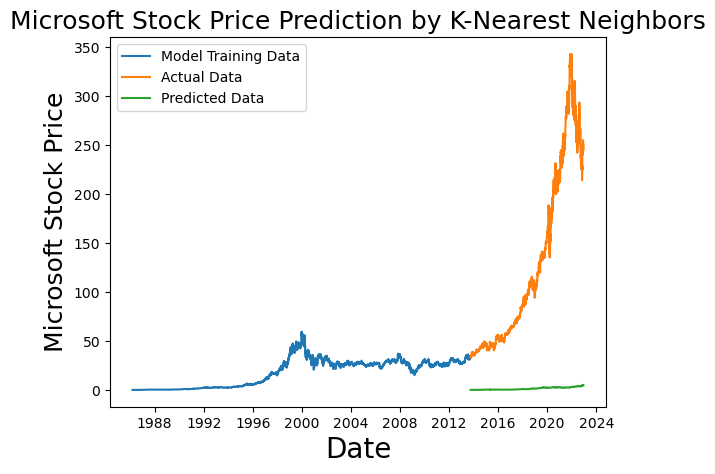

In [19]:
def K_Nearest_Neighbours_Predict_2(msft_df):
    shape = msft_df.shape[0]
    msft_df_new = msft_df[['Close']]
    msft_df_new.head()
    
    train_data_set_msft = msft_df_new.iloc[:ceil(shape*0.75)]
    test_data_set_msft = msft_df_new.iloc[ceil(shape*0.75):]
    
    print("*********Microsoft STOCK PRICE PREDICTION BY K-NEAREST NEIGHBORS*********")
    print('Shape of Training Data Set', train_data_set_msft.shape)
    print('Shape of Test Data Set', test_data_set_msft.shape)
    
    
    train_msft = train_data_set_msft.reset_index()
    test_msft = test_data_set_msft.reset_index()
    x_train_msft = train_msft.index.values.reshape(-1, 1)  # Assuming index represents Date
    y_train_msft = train_msft[['Close']]
    x_test_msft= test_msft.index.values.reshape(-1, 1)  # Assuming index represents Date
    y_test_msft= test_msft[['Close']]
    
    scaler = MinMaxScaler()
    x_train_scaled_msft = scaler.fit_transform(x_train_msft)
    x_train_msft = pd.DataFrame(x_train_scaled_msft)
    x_test_scaled_msft = scaler.transform(x_test_msft)
    x_test_msft = pd.DataFrame(x_test_scaled_msft)
    
    params_msft = {'n_neighbors': [2, 3, 4, 5, 6, 7, 8, 9]}
    knn = neighbors.KNeighborsRegressor()
    model_msft = GridSearchCV(knn, params_msft, cv=5)
    model_msft.fit(x_train_msft, y_train_msft)
    preds_msft = model_msft.predict(x_test_msft)
    RMS_msft= np.sqrt(np.mean(np.power((np.array(y_test_msft) - np.array(preds_msft)), 2)))
    print('(Root Mean Square Error) RMSE value on validation set:', RMS_msft)
    test_data_set_msft['Predictions'] = preds_msft

    # Calculate R-squared and adjusted R-squared
    r_squared_msft = r2_score(y_test_msft, preds_msft)
    n_msft = len(y_test_msft)
    p_msft= x_test_msft.shape[1]  # Number of features
    adj_r_squared_msft = 1 - (1 - r_squared_msft) * (n_msft - 1) / (n_msft - p_msft - 1)
    print("R-squared:", r_squared_msft)
    print("Adjusted R-squared:", adj_r_squared_msft)

    plt.plot(train_data_set_msft['Close'])
    plt.plot(test_data_set_msft[['Close', 'Predictions']])
    plt.xlabel('Date', size=20)
    plt.ylabel('Microsoft Stock Price', size=18)
    plt.title('Microsoft Stock Price Prediction by K-Nearest Neighbors', size=18)
    plt.legend(['Model Training Data', 'Actual Data', 'Predicted Data'])
    plt.show()

# Example usage:
K_Nearest_Neighbours_Predict_2(msft_df)